In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

In [2]:
df = pd.read_csv('mlb_game_data_2025.csv')  # Load your dataset

In [3]:
y = df['Home Team Won'].to_numpy()

feature_columns= [
    'Difference strikeouts',               
    'Difference baseonballs']

X = df[feature_columns].to_numpy()

X_normalized = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))

print(np.shape(X), np.shape(y))

(2463, 2) (2463,)


In [4]:
np.random.seed(42)

features, label = X_normalized, y
 
train_data, test_data, train_labels, test_labels = train_test_split(
    features, label, test_size=0.3, random_state=246
)

In [5]:
import qiskit
qiskit.__version__

'1.2.4'

In [6]:
from qiskit.circuit.library import ZFeatureMap
 
# One qubit per data feature
num_qubits = len(train_data[0])
print(f"Number of qubits: {num_qubits}")
 
# Data encoding
# Note that qiskit orders parameters alphabetically. We assign the parameter prefix "a" to ensure our data encoding goes to the first part of the circuit, the feature mapping.
feature_map = ZFeatureMap(num_qubits, parameter_prefix="a")

Number of qubits: 2


3
2+ qubit depth: 1


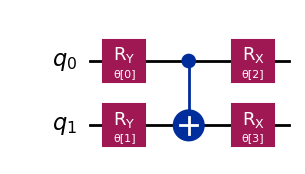

In [7]:
# Import the necessary packages
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector

size = num_qubits
 
# Initialize the circuit using the same number of qubits as the image has pixels
qnn_circuit = QuantumCircuit(size)
 
# We choose to have two variational parameters for each qubit.
params = ParameterVector("θ", length=2 * size)
 
# A first variational layer:
for i in range(size):
    qnn_circuit.ry(params[i], i)
 
# Here is a list of qubit pairs between which we want CNOT gates. The choice of these is not yet obvious.
qnn_cnot_list = [[0, 1]]
 
for i in range(len(qnn_cnot_list)):
    qnn_circuit.cx(qnn_cnot_list[i][0], qnn_cnot_list[i][1])
 
# The second variational layer:
for i in range(size):
    qnn_circuit.rx(params[size + i], i)
 
# Check the circuit depth, and the two-qubit gate depth
print(qnn_circuit.decompose().depth())
print(
    f"2+ qubit depth: {qnn_circuit.decompose().depth(lambda instr: len(instr.qubits) > 1)}"
)
 
# Draw the circuit
qnn_circuit.draw("mpl")

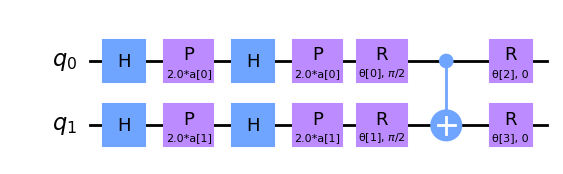

In [8]:
# QNN ansatz
ansatz = qnn_circuit
 
# Combine the feature map with the ansatz
full_circuit = QuantumCircuit(num_qubits)
full_circuit.compose(feature_map, range(num_qubits), inplace=True)
full_circuit.compose(ansatz, range(num_qubits), inplace=True)
 
# Display the circuit
full_circuit.decompose().draw("mpl", style="clifford", fold=-1)

In [9]:
from qiskit.quantum_info import SparsePauliOp
 
observable = SparsePauliOp.from_list([("Z" * (num_qubits), 1)])

In [10]:
from qiskit.primitives import BaseEstimatorV2
from qiskit.quantum_info.operators.base_operator import BaseOperator
 
 
def forward(
    circuit: QuantumCircuit,
    input_params: np.ndarray,
    weight_params: np.ndarray,
    estimator: BaseEstimatorV2,
    observable: BaseOperator,
) -> np.ndarray:
    """
    Forward pass of the neural network.
 
    Args:
        circuit: circuit consisting of data loader gates and the neural network ansatz.
        input_params: data encoding parameters.
        weight_params: neural network ansatz parameters.
        estimator: EstimatorV2 primitive.
        observable: a single observable to compute the expectation over.
 
    Returns:
        expectation_values: an array (for one observable) or a matrix (for a sequence of observables) of expectation values.
        Rows correspond to observables and columns to data samples.
    """
    num_samples = input_params.shape[0]
    weights = np.broadcast_to(weight_params, (num_samples, len(weight_params)))
    params = np.concatenate((input_params, weights), axis=1)
    pub = (circuit, observable, params)
    job = estimator.run([pub])
    result = job.result()[0]
    expectation_values = result.data.evs
 
    return expectation_values

In [11]:
def mse_loss(predict: np.ndarray, target: np.ndarray) -> np.ndarray:
    """
    Mean squared error (MSE).
 
    prediction: predictions from the forward pass of neural network.
    target: true labels.
 
    output: MSE loss.
    """
    if len(predict.shape) <= 1:
        return ((predict - target) ** 2).mean()
    else:
        raise AssertionError("input should be 1d-array")

In [12]:
def mse_loss_weights(weight_params: np.ndarray) -> np.ndarray:
    """
    Cost function for the optimizer to update the ansatz parameters.
 
    weight_params: ansatz parameters to be updated by the optimizer.
 
    output: MSE loss.
    """
    predictions = forward(
        circuit=circuit,
        input_params=input_params,
        weight_params=weight_params,
        estimator=estimator,
        observable=observable,
    )
 
    cost = mse_loss(predict=predictions, target=target)
    objective_func_vals.append(cost)
 
    global iter
    if iter % 50 == 0:
        print(f"Iter: {iter}, loss: {cost}")
    iter += 1
 
    return cost

In [13]:
from scipy.optimize import minimize

In [14]:
# Globals
circuit = full_circuit
observables = observable
# input_params = train_images_batch
# target = train_labels_batch
objective_func_vals = []
iter = 0

In [16]:
from qiskit_aer import AerSimulator

In [17]:
backend = AerSimulator()
from qiskit.circuit.library import XGate
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import (
    ALAPScheduleAnalysis,
    ConstrainedReschedule,
    PadDynamicalDecoupling,
)
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
 
target = backend.target

pm = generate_preset_pass_manager(
    target=target,
    optimization_level=3,
    routing_method="basic",          # avoids routing plugin
    layout_method="trivial",         # avoids layout plugin
    translation_method="translator", # avoids translation plugin ("unroller" also works)
    scheduling_method=None           # you schedule below
)

pm.scheduling = PassManager(
    [
        ALAPScheduleAnalysis(target=target),
        ConstrainedReschedule(
            acquire_alignment=target.acquire_alignment,
            pulse_alignment=target.pulse_alignment,
            target=target,
        ),
        PadDynamicalDecoupling(
            target=target,
            dd_sequence=[XGate(), XGate()],
            pulse_alignment=target.pulse_alignment,
        ),
    ]
)

In [18]:
circuit_ibm = pm.run(full_circuit)
observable_ibm = observable.apply_layout(circuit_ibm.layout)

TranspilerError: 'Duration of rx on qubits [1] is not found.'

In [25]:
from qiskit.primitives import StatevectorEstimator as Estimator
 
batch_size = 140
num_epochs = 1
num_samples = len(train_data)
 
# Globals
circuit = full_circuit
estimator = Estimator()  # simulator for debugging
observables = observable
objective_func_vals = []
iter = 0
 
# Random initial weights for the ansatz
np.random.seed(42)
weight_params = np.random.rand(len(ansatz.parameters)) * 2 * np.pi
 
for epoch in range(num_epochs):
    for i in range((num_samples - 1) // batch_size + 1):
        print(f"Epoch: {epoch}, batch: {i}")
        start_i = i * batch_size
        end_i = start_i + batch_size
        train_images_batch = np.array(train_data[start_i:end_i])
        train_labels_batch = np.array(train_labels[start_i:end_i])
        input_params = train_images_batch
        target = train_labels_batch
        iter = 0
        res = minimize(
            mse_loss_weights, weight_params, method="COBYLA", options={"maxiter": 100}
        )
        weight_params = res["x"]

Epoch: 0, batch: 0
Iter: 0, loss: 0.3693872162899964
Iter: 50, loss: 0.21681877703868327
Epoch: 0, batch: 1
Iter: 0, loss: 0.2355386776483559
Iter: 50, loss: 0.22913281608076871
Epoch: 0, batch: 2
Iter: 0, loss: 0.24743508201280753
Iter: 50, loss: 0.23088989335671986
Epoch: 0, batch: 3
Iter: 0, loss: 0.23964493042495075
Iter: 50, loss: 0.22667257000335952
Epoch: 0, batch: 4
Iter: 0, loss: 0.2027288591343523
Iter: 50, loss: 0.19956422078712036
Epoch: 0, batch: 5
Iter: 0, loss: 0.19255942854615796
Iter: 50, loss: 0.18441815612527754
Epoch: 0, batch: 6
Iter: 0, loss: 0.19119768886223693
Iter: 50, loss: 0.1879985895533212
Epoch: 0, batch: 7
Iter: 0, loss: 0.21236329871935616
Iter: 50, loss: 0.20545280238957264
Epoch: 0, batch: 8
Iter: 0, loss: 0.20024366899939317
Iter: 50, loss: 0.19314158999083467
Epoch: 0, batch: 9
Iter: 0, loss: 0.22526202605543538
Iter: 50, loss: 0.22012415460662146
Epoch: 0, batch: 10
Iter: 0, loss: 0.2199486748459242
Iter: 50, loss: 0.21656848158530703
Epoch: 0, batc

In [26]:
import copy
from sklearn.metrics import accuracy_score
from qiskit.primitives import StatevectorEstimator as Estimator  # simulator
# from qiskit_ibm_runtime import EstimatorV2 as Estimator  # real quantum computer
 
estimator = Estimator()
# estimator = Estimator(backend=backend)
 
pred_train = forward(circuit, np.array(train_data), res["x"], estimator, observable)
# pred_train = forward(circuit_ibm, np.array(train_images), res['x'], estimator, observable_ibm)
 
print(pred_train)
 
pred_train_labels = copy.deepcopy(pred_train)
pred_train_labels[pred_train_labels >= 0] = 1
pred_train_labels[pred_train_labels < 0] = -1
print(pred_train_labels)
print(train_labels)
 
accuracy = accuracy_score(train_labels, pred_train_labels)
print(f"Train accuracy: {accuracy * 100}%")

[0.50256336 0.70668338 0.53195783 ... 0.52536534 0.4774954  0.47231555]
[1. 1. 1. ... 1. 1. 1.]
[False  True  True ...  True  True False]
Train accuracy: 53.596287703016245%


In [27]:
pred_test = forward(circuit, np.array(test_data), res["x"], estimator, observable)
# pred_test = forward(circuit_ibm, np.array(test_images), res['x'], estimator, observable_ibm)
 
print(pred_test)
 
pred_test_labels = copy.deepcopy(pred_test)
pred_test_labels[pred_test_labels >= 0] = 1
pred_test_labels[pred_test_labels < 0] = -1
print(pred_test_labels)
print(test_labels)
 
accuracy = accuracy_score(test_labels, pred_test_labels)
print(f"Test accuracy: {accuracy * 100}%")

[ 0.50654361  0.77848572  0.61051832  0.5819963   0.47382428  0.52394821
  0.08106437  0.6963139   0.8231967   0.49823433  0.45500081  0.40603067
  0.50654361  0.19597037  0.65847557  0.06350665  0.50256336  0.6580545
  0.4545157   0.63501056  0.47126228  0.68162463  0.71241795  0.5819963
  0.23811247  0.43582076  0.29171964  0.5460841   0.5460841   0.50682987
  0.40603067  0.61912176  0.35663807  0.47880841  0.33992204  0.72281251
  0.63501056  0.68303714  0.60545593  0.72665269  0.6580545   0.60574306
  0.68536362  0.45429964  0.70668338  0.71473113  0.42918384  0.72842469
  0.50654361  0.56157829  0.37014287  0.45795562  0.53312087  0.75499708
  0.5819963   0.51427344  0.70372929  0.34684429  0.4545157   0.5819963
  0.45716405  0.77848572  0.43407723  0.69206353  0.56655608  0.58500246
  0.67925468  0.55890899  0.63206039  0.50256336  0.62924888  0.36052933
  0.56157829  0.67925468  0.68303714  0.70668338  0.57824921  0.61051832
  0.49781627  0.63501056  0.4545157   0.38028644  0.49

In [29]:
import matplotlib.pyplot as plt

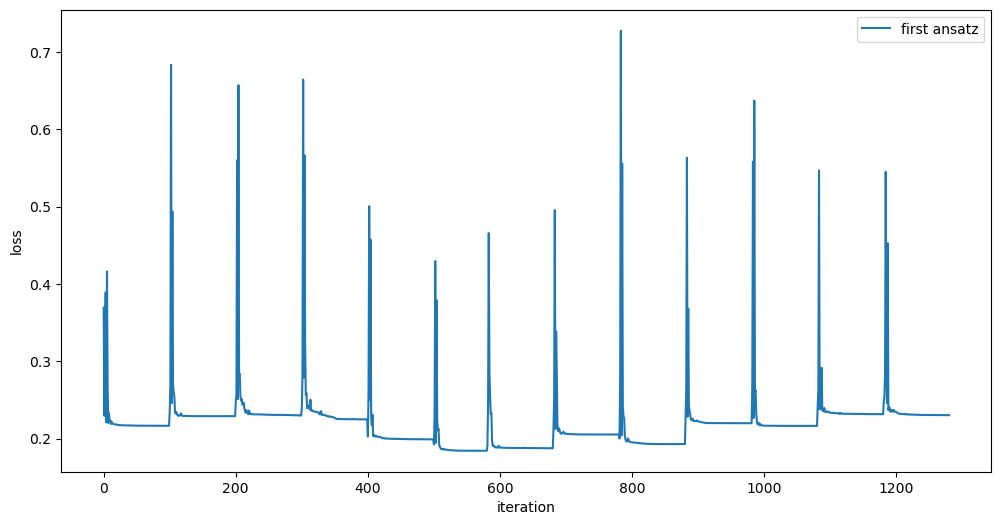

In [30]:
obj_func_vals_first = objective_func_vals
# import matplotlib.pyplot as plt
 
plt.figure(figsize=(12, 6))
plt.plot(obj_func_vals_first, label="first ansatz")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.legend()
plt.show()

In [31]:
missed = []
for i in range(len(test_labels)):
    if pred_test_labels[i] != test_labels[i]:
        missed.append(test_data[i])
print(len(missed))

323


3
2+ qubit depth: 1


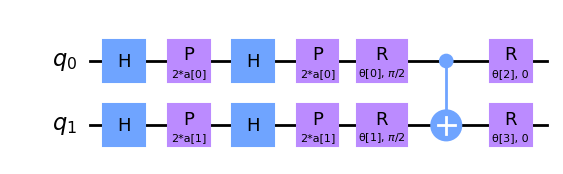

In [33]:
# Initialize the circuit using the same number of qubits as the image has pixels
qnn_circuit = QuantumCircuit(size)
 
# We choose to have two variational parameters for each qubit.
params = ParameterVector("θ", length=2 * size)
 
# A first variational layer:
for i in range(size):
    qnn_circuit.ry(params[i], i)
 
# Here is an extended list of qubit pairs between which we want CNOT gates. This now covers all pixels connected by horizontal lines.
qnn_cnot_list = [[0, 1]]
 
for i in range(len(qnn_cnot_list)):
    qnn_circuit.cx(qnn_cnot_list[i][0], qnn_cnot_list[i][1])
 
# The second variational layer:
for i in range(size):
    qnn_circuit.rx(params[size + i], i)
 
# Check the circuit depth, and the two-qubit gate depth
print(qnn_circuit.decompose().depth())
print(
    f"2+ qubit depth: {qnn_circuit.decompose().depth(lambda instr: len(instr.qubits) > 1)}"
)
 
# Combine the feature map and variational circuit
ansatz = qnn_circuit
 
# Combine the feature map with the ansatz
full_circuit = QuantumCircuit(num_qubits)
full_circuit.compose(feature_map, range(num_qubits), inplace=True)
full_circuit.compose(ansatz, range(num_qubits), inplace=True)
 
# Display the circuit
full_circuit.decompose().draw("mpl", style="clifford", fold=-1)

In [34]:
from qiskit.primitives import StatevectorEstimator as Estimator
 
batch_size = 140
num_epochs = 1
num_samples = len(train_data)
 
# Globals
circuit = full_circuit
estimator = Estimator()  # simulator for debugging
observables = observable
objective_func_vals = []
iter = 0
 
# Random initial weights for the ansatz
np.random.seed(42)
weight_params = np.random.rand(len(ansatz.parameters)) * 2 * np.pi
 
for epoch in range(num_epochs):
    for i in range((num_samples - 1) // batch_size + 1):
        print(f"Epoch: {epoch}, batch: {i}")
        start_i = i * batch_size
        end_i = start_i + batch_size
        train_images_batch = np.array(train_data[start_i:end_i])
        train_labels_batch = np.array(train_labels[start_i:end_i])
        input_params = train_images_batch
        target = train_labels_batch
        iter = 0
        res = minimize(
            mse_loss_weights, weight_params, method="COBYLA", options={"maxiter": 100}
        )
        weight_params = res["x"]

Epoch: 0, batch: 0
Iter: 0, loss: 0.3693872162899964
Iter: 50, loss: 0.21681877703868327
Epoch: 0, batch: 1
Iter: 0, loss: 0.2355386776483559
Iter: 50, loss: 0.22913281608076871
Epoch: 0, batch: 2
Iter: 0, loss: 0.24743508201280753
Iter: 50, loss: 0.23088989335671986
Epoch: 0, batch: 3
Iter: 0, loss: 0.23964493042495075
Iter: 50, loss: 0.22667257000335952
Epoch: 0, batch: 4
Iter: 0, loss: 0.2027288591343523
Iter: 50, loss: 0.19956422078712036
Epoch: 0, batch: 5
Iter: 0, loss: 0.19255942854615796
Iter: 50, loss: 0.18441815612527754
Epoch: 0, batch: 6
Iter: 0, loss: 0.19119768886223693
Iter: 50, loss: 0.1879985895533212
Epoch: 0, batch: 7
Iter: 0, loss: 0.21236329871935616
Iter: 50, loss: 0.20545280238957264
Epoch: 0, batch: 8
Iter: 0, loss: 0.20024366899939317
Iter: 50, loss: 0.19314158999083467
Epoch: 0, batch: 9
Iter: 0, loss: 0.22526202605543538
Iter: 50, loss: 0.22012415460662146
Epoch: 0, batch: 10
Iter: 0, loss: 0.2199486748459242
Iter: 50, loss: 0.21656848158530703
Epoch: 0, batc

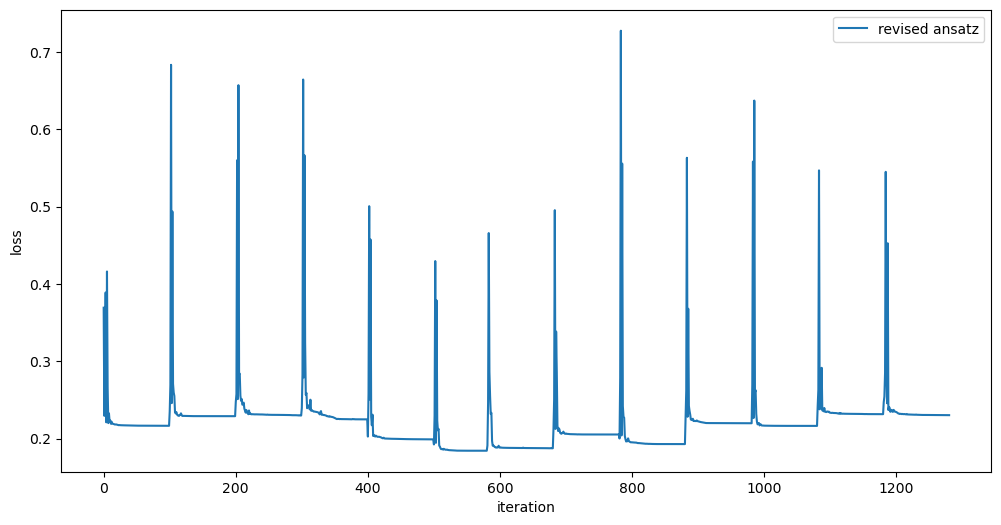

In [35]:
obj_func_vals_revised = objective_func_vals
# import matplotlib.pyplot as plt
 
plt.figure(figsize=(12, 6))
plt.plot(obj_func_vals_revised, label="revised ansatz")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.legend()
plt.show()

In [42]:
from sklearn.metrics import accuracy_score
from qiskit.primitives import StatevectorEstimator as Estimator  # simulator
# from qiskit_ibm_runtime import EstimatorV2 as Estimator  # real quantum computer
 
estimator = Estimator()
# estimator = Estimator(backend=backend)
 
pred_train = forward(circuit, np.array(train_data), res["x"], estimator, observable)
# pred_train = forward(circuit_ibm, np.array(train_images), res['x'], estimator, observable_ibm)
 
print(pred_train)
 
pred_train_labels = copy.deepcopy(pred_train)
pred_train_labels[pred_train_labels >= 0] = 1
pred_train_labels[pred_train_labels < 0] = -1
print(pred_train_labels)
print(train_labels)
 
accuracy = accuracy_score(train_labels, pred_train_labels)
print(f"Train accuracy: {accuracy * 100}%")

[0.50256336 0.70668338 0.53195783 ... 0.52536534 0.4774954  0.47231555]
[1. 1. 1. ... 1. 1. 1.]
[False  True  True ...  True  True False]
Train accuracy: 53.596287703016245%


In [45]:
from qiskit_machine_learning.algorithms.classifiers import  VQC

ImportError: cannot import name 'BaseEstimator' from 'qiskit.primitives' (/opt/anaconda3/envs/qlm/lib/python3.11/site-packages/qiskit/primitives/__init__.py)